In [1]:
%load_ext autoreload
%load_ext autotime

time: 325 µs (started: 2023-09-24 22:24:31 -07:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

time: 1.27 s (started: 2023-09-24 22:24:31 -07:00)


In [3]:
import csv
import dask
import dask.dataframe as dd
import json
import numpy as np
import pandas as pd
print('pandas', pd.__version__)
print('dask', dask.__version__)
print('numpy', np.__version__)

pandas 1.5.3
dask 2022.12.1
numpy 1.21.0
time: 641 ms (started: 2023-09-24 22:24:32 -07:00)


In [4]:
%autoreload 2

from wisio.recorder import RecorderAnalyzer

log_dir = "/p/vast1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"
n_workers = 16

analyzer = RecorderAnalyzer(
    cluster_manager_args=dict(
#         force_local=True,
        cluster_settings=dict(
            cores=n_workers,
            dashboard_port=3616,
            local_directory="/var/tmp/dask-recorder",
            log_file="%J.log",
            memory=n_workers * 200,
            worker_queue="pdebug"
        )
    ),
    working_dir='.recorder',
    debug=True
) 

analyzer

time: 1.42 s (started: 2023-09-24 22:24:33 -07:00)


In [5]:
client = analyzer.cluster_manager.clients[0]
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:3616/status,
Dashboard: http://192.168.66.200:3616/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:45625,Workers: 0
Dashboard: http://192.168.66.200:3616/status,Total threads: 0
Started: Just now,Total memory: 0 B


time: 36.4 ms (started: 2023-09-24 22:24:36 -07:00)


In [6]:
%autoreload 2

result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints",
    metrics=['duration'],
)

time: 1h 30min 17s (started: 2023-09-24 20:13:02 -07:00)


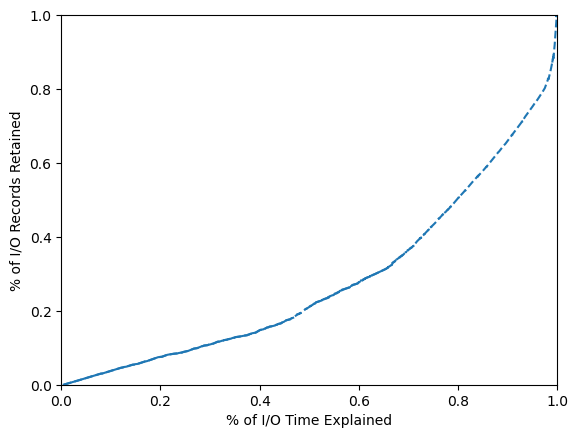

time: 13.9 s (started: 2023-09-24 21:44:23 -07:00)


In [7]:
ax, _ = result.plot.slope(
    metric='duration',
    view_keys=[('time_range',)],
#     ax=ax,
    xlabel='% of I/O Time Explained',
    ylabel='% of I/O Records Retained',
#     color=f"C{i}"
)
ax

In [12]:
fig, ax = result.plot.view_relations3(
    metric='duration',
    view_key1=('time_range',),
    view_key2=('file_name',),
    view_key3=('proc_name',),
    label1='Time-based',
    label2='File-based',
    label3='Process-based'
)
ax.get_legend().remove()

AttributeError: 'builtin_function_or_method' object has no attribute 'map'

time: 1.27 s (started: 2023-09-24 21:58:30 -07:00)


In [13]:
from wisio.rules import Rule
from wisio._recorder.rules import RecorderRuleEngine

rules = dict(
    # app_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_dir=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_regex=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # node_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # proc_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # rank=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    time_range=[Rule.BOTT_METADATA_ACCESS],
)

rule_engine = RecorderRuleEngine(rules=rules)

rule_engine


time: 4.13 ms (started: 2023-09-24 22:01:34 -07:00)


In [14]:
%autoreload 2

characteristics = rule_engine.process_characteristics(view=result.main_view)
characteristics


AttributeError: 'builtin_function_or_method' object has no attribute 'map'

time: 890 ms (started: 2023-09-24 22:01:36 -07:00)


In [ ]:
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.tree import Tree

# Create a new Table object from Rich library
table = Table(box=None, show_header=False)

# Add columns to the table for the key and value
table.add_column(style="cyan")
table.add_column()

# Add each key-value pair to the table as a row
for rule, result in characteristics.items():
    if result.detail_list is None:
        table.add_row(result.description, result.value_fmt)
    else:
        detail_tree = Tree(result.value_fmt)
        for detail in result.detail_list:
            detail_tree.add(detail)
        table.add_row(result.description, detail_tree)

# Create a Console object from Rich library
console = Console()

# Print the table with Rich formatting
console.print(Panel(table, title='Summary'))
